In [ ]:
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Convolution2D
from keras import utils
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from PIL import Image
import os

In [ ]:
data_path = "/content/drive/MyDrive/archive"
train_path = os.path.join(data_path, "train")

for vehicle_type in os.listdir(train_path):
  vehicle_type_path = os.path.join(train_path, vehicle_type)
  #print(vehicle_type, vehicle_type_path)
  num_type = 0
  for vehicle in os.listdir(vehicle_type_path):
    img_path = os.path.join(vehicle_type_path, vehicle)
    img = Image.open(img_path)
    num_type += 1
  print(vehicle_type, num_type)

fire engine 140
truck 140
racing car 140
taxi 140
heavy truck 140
SUV 140
jeep 140
minibus 140
family sedan 140
bus 140


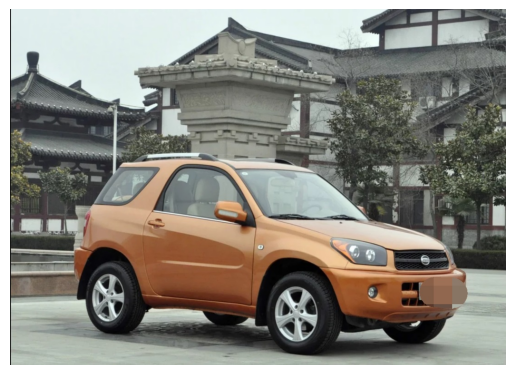

(1077, 772)

In [ ]:
img = Image.open("/content/drive/MyDrive/archive/train/SUV/03ec6d0d0d0b206b4f2188d059b44673.jpg")
plt.imshow(img)
plt.axis('off') # to turn off axis
plt.show()
img.size

In [ ]:
image_size = (180, 180)
batch_size = 32

test_path = os.path.join(data_path, "val")
#test_path = os.path.join(data_path, "test")

train_ds, val_ds = keras.utils.image_dataset_from_directory(train_path, image_size = image_size, batch_size = batch_size, crop_to_aspect_ratio=True, validation_split=0.2, subset = "both", seed = 1337)
test_ds = keras.utils.image_dataset_from_directory(test_path, image_size = image_size, batch_size = batch_size, crop_to_aspect_ratio=True)
#test_ds = keras.utils.image_dataset_from_directory(test_path, image_size = image_size, batch_size = batch_size)

Found 1400 files belonging to 10 classes.
Using 1120 files for training.
Using 280 files for validation.
Found 200 files belonging to 10 classes.


In [ ]:
def data_augmentation(images):
    return images

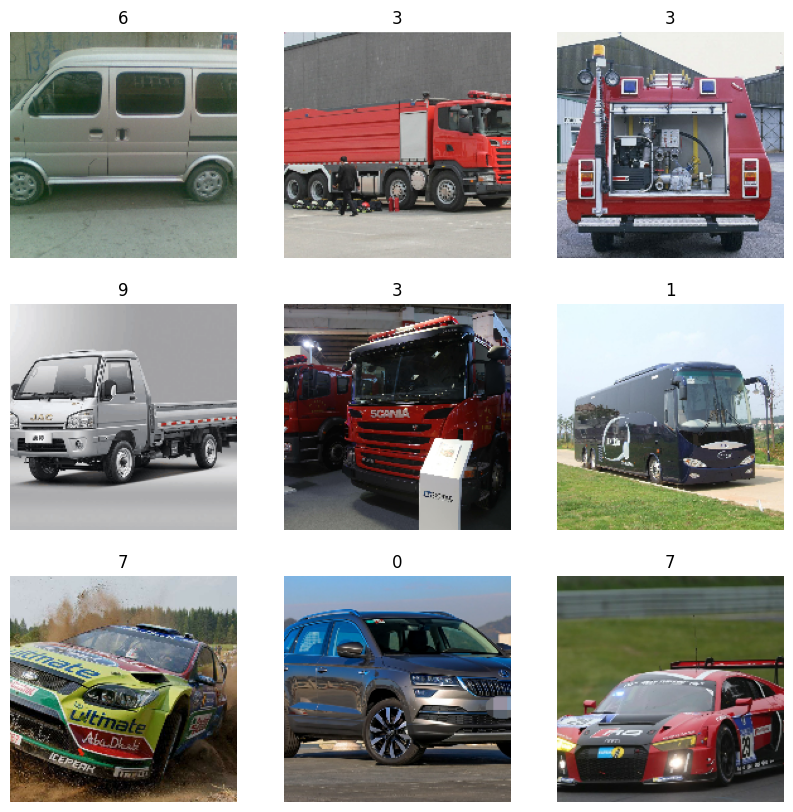

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)

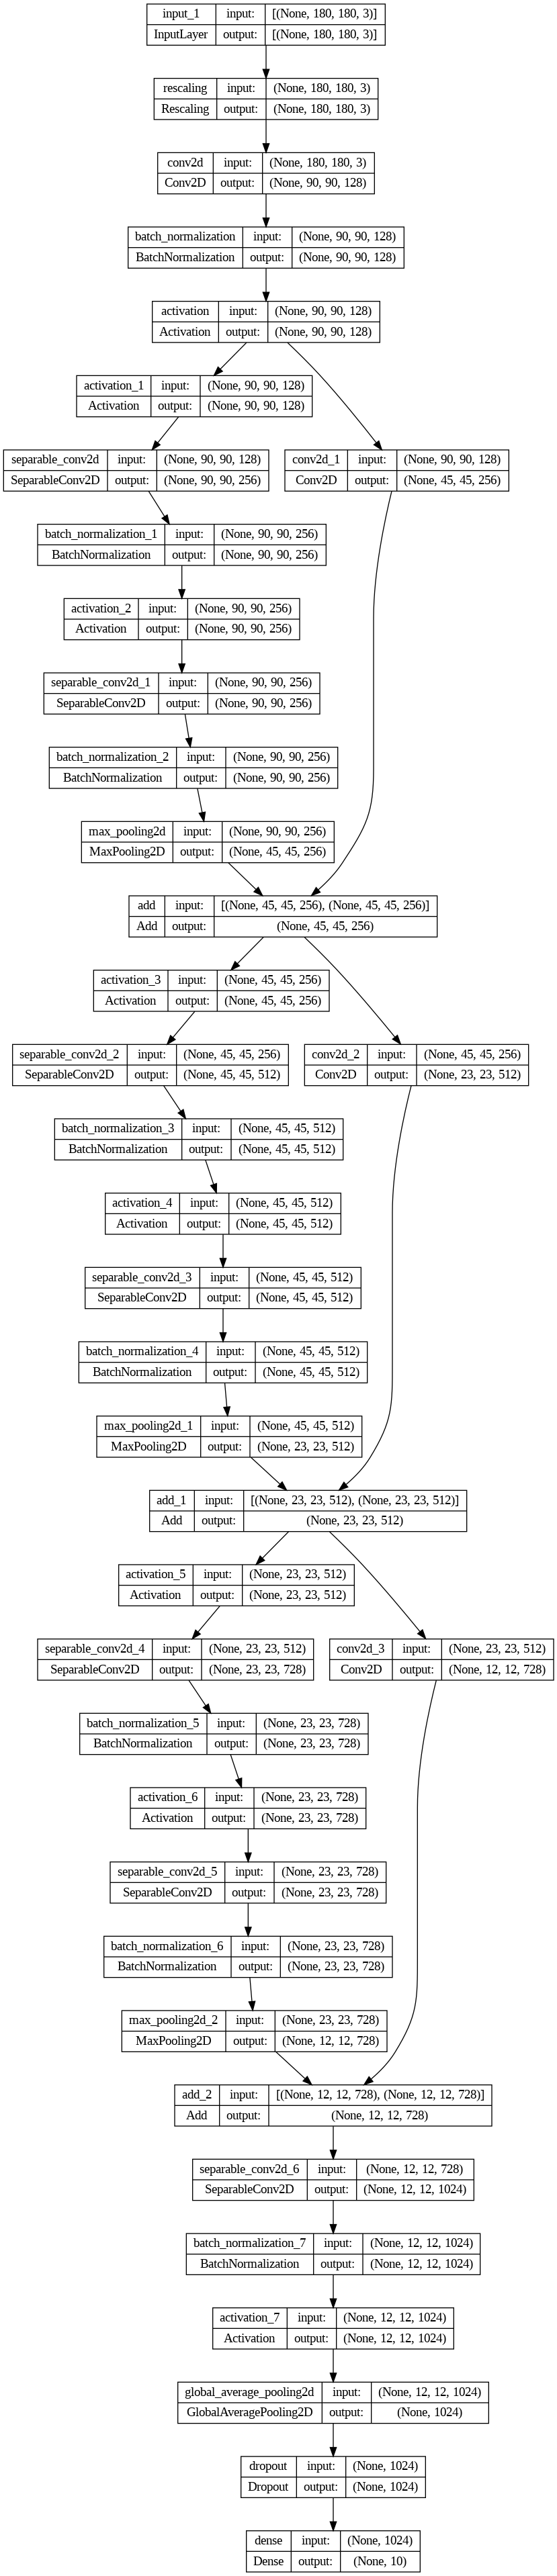

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras.layers import MaxPooling2D, Dense, Dropout

model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 flatten (Flatten)           (None, 253472)            0         
                                                                 
 dense_1 (Dense)             (None, 10)                2534730   
                                                                 
Total params: 2535626 (9.67 MB)
Trainable params: 2535626 (9.67 MB)
Non-trainable params: 0 (0.00 Byte)
__________________



*   visualize loss
*   look at metrics for current model using classification report



In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/25
35/35 [==============================] - 24s 482ms/step - loss: 1.6746 - accuracy: 0.9464 - val_loss: 61.4317 - val_accuracy: 0.4036
Epoch 2/25
35/35 [==============================] - 22s 520ms/step - loss: 0.5984 - accuracy: 0.9759 - val_loss: 39.7633 - val_accuracy: 0.5179
Epoch 3/25
35/35 [==============================] - 22s 550ms/step - loss: 0.2525 - accuracy: 0.9875 - val_loss: 43.1139 - val_accuracy: 0.4571
Epoch 4/25
35/35 [==============================] - 19s 465ms/step - loss: 1.6042 - accuracy: 0.9554 - val_loss: 45.0307 - val_accuracy: 0.4429
Epoch 5/25
35/35 [==============================] - 23s 529ms/step - loss: 1.5084 - accuracy: 0.9527 - val_loss: 45.4270 - val_accuracy: 0.4821
Epoch 6/25
35/35 [==============================] - 21s 523ms/step - loss: 0.4696 - accuracy: 0.9804 - val_loss: 35.3653 - val_accuracy: 0.4679
Epoch 7/25
35/35 [==============================] - 23s 542ms/step - loss: 0.1669 - accuracy: 0.9946 - val_loss: 34.0764 - val_accuracy:

In [ ]:
score = model.evaluate(test_ds, verbose=0)
print(score)

[28.125505447387695, 0.5450000166893005]


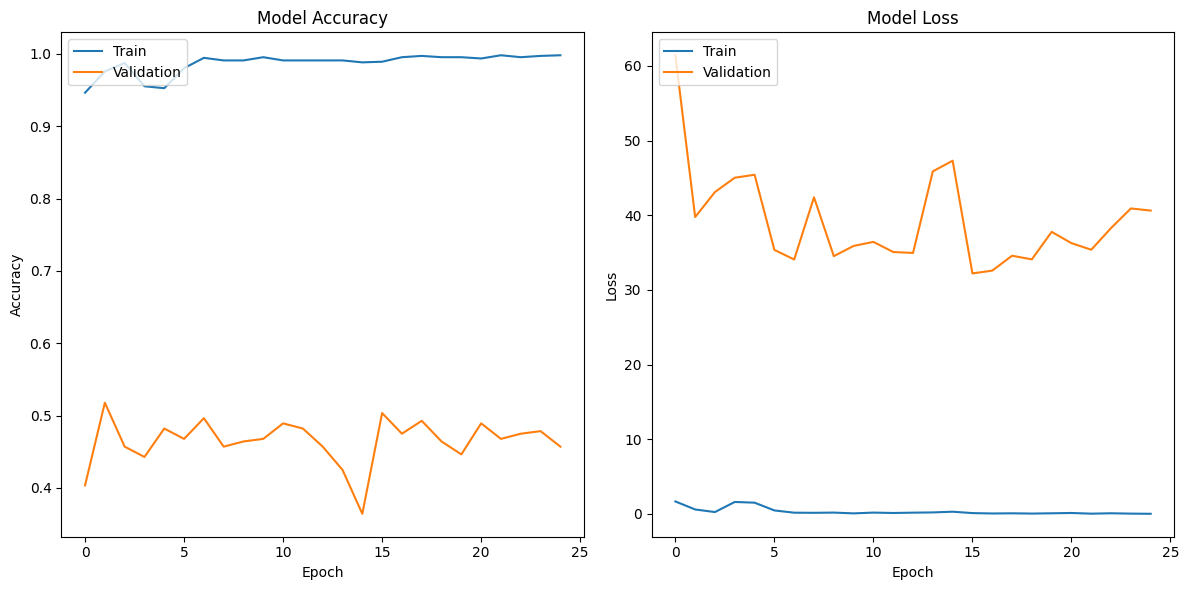

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

AttributeError: module 'keras' has no attribute 'ops'

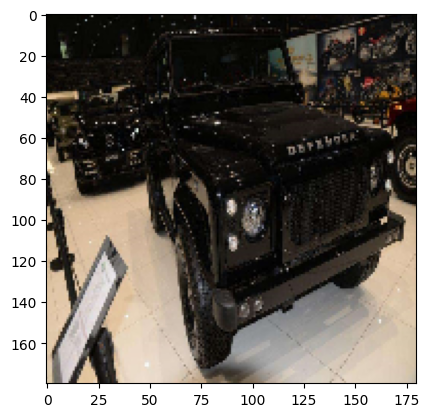

In [ ]:
img = keras.utils.load_img("/content/drive/MyDrive/archive/test/01ab0c4e74e5cefbc25e78e8b2b4b30d.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
score